In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from keras.engine import input_layer
from keras.models import Sequential
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)


def local_model_generate(model, look_back): #초기 모델 생성
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


def dataset_processing(local_dataset, MinMax_scaler, train, test):

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print("train test size: ",len(trainX), len(trainY), len(testX), len(testY))
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX, trainY, testY


    
def model_test(local_model, MinMax_scaler, trainX, testX, trainY, testY):
    trainPredict = local_model.predict(trainX)
    testPredict = local_model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    return math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])), math.sqrt(mean_squared_error(testY[0], testPredict[:,0])) #RMSE



In [3]:
#발전기명, 년월일, 설비용량(MW)	01시	02시	03시	04시	05시	06시	07시	08시	09시	10시	11시	12시	13시	14시	15시	16시	17시	18시	19시	20시	21시	22시	23시	24시

dataset1 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_세종.csv', encoding='cp949')
dataset2 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_안산.csv', encoding='cp949')
dataset3 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_영암.csv', encoding='cp949')


In [4]:
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("Before : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

dataset1, dataset2, dataset3 = dataset1.fillna(0), dataset2.fillna(0), dataset3.fillna(0)
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("After : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

Before :  6 5 1
After :  0 0 0


In [5]:
new_dataset1, new_dataset2, new_dataset3 = [], [], []

for i in range(len(dataset1)):
    new_dataset1.extend(dataset1.iloc[i,3:])

for i in range(len(dataset2)):
    new_dataset2.extend(dataset2.iloc[i,3:])

for i in range(len(dataset3)):
    new_dataset3.extend(dataset3.iloc[i,3:])
    
len(new_dataset1), len(new_dataset2), len(new_dataset3)

(40728, 40728, 40728)

#### 데이터 월단위로 나눔
#### 2017.01.01 ~ 2021.08.31

한달 = 1 global epoch => 12+12+12+12+8 = 56 local epoch


In [6]:
num_locals = 3
ratio_train_test = 1.0

period_1 = [31,28,31,23,31,30,31,31,30,31,30,31]
period_2 = [31,28,31,30,31,30,31,31,30,31,30,31]
period_3 = [31,28,31,30,31,30,31,31,30,31,30,31]
period_4 = [31,29,31,30,31,30,31,31,30,31,30,31]
period_5 = [31,28,31,30,31,30,31,31]

scaler = MinMaxScaler(feature_range=(0,1))

for local in range(1,num_locals+1):
    tmp = 0
    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            for k in range(globals()['period_{}'.format(i)][j]):    
                globals()['dataset{}_{}_{}'.format(local,i,j)] = globals()['new_dataset{}'.format(local)][tmp:tmp+globals()['period_{}'.format(i)][j]]
            #print(i,j,len(globals()['dataset{}_{}_{}'.format(local,i,j)]))
            
    tmp3 = 0
    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            tmp3 = tmp3 + len(globals()['dataset{}_{}_{}'.format(local,i,j)])

    print(tmp3, (np.sum(period_1)+np.sum(period_2)+np.sum(period_3)+np.sum(period_4)+np.sum(period_5)))

    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            globals()['local{}_{}_{}'.format(local,i,j)] = scaler.fit_transform(np.array(globals()['dataset{}_{}_{}'.format(local,i,j)]).reshape(-1, 1))
            
            local_var = globals()['local{}_{}_{}'.format(local,i,j)]
            globals()['train_size{}_{}_{}'.format(local,i,j)] = int(len(local_var)*ratio_train_test)
            globals()['test_size{}_{}_{}'.format(local,i,j)] = len(local_var) - globals()['train_size{}_{}_{}'.format(local,i,j)]
            train_sz,test_sz = globals()['train_size{}_{}_{}'.format(local,i,j)], globals()['test_size{}_{}_{}'.format(local,i,j)]
            
            globals()['train{}_{}_{}'.format(local,i,j)], globals()['test{}_{}_{}'.format(local,i,j)] = local_var[0:train_sz, :], local_var[test_sz:len(local_var),:]
            globals()['train{}_{}_{}'.format(local,i,j)], globals()['test{}_{}_{}'.format(local,i,j)] = list(globals()['train{}_{}_{}'.format(local,i,j)].reshape(-1)), list(globals()['test{}_{}_{}'.format(local,i,j)].reshape(-1))
            

1697 1697
1697 1697
1697 1697


In [7]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def build_model():
    model = keras.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(1, len(train_dataset.keys()))),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',  optimizer='adam', metrics=['mae', 'mse'])
    return model


In [8]:
EPOCHS = 7
num_layers_list = [0,1,2]
selected_locals = 3
Val_Loss, Loss = [], []

loss_tmp, val_loss_tmp = [], []

for local in range(1,num_locals+1):
    df = pd.DataFrame({'local':globals()['train{}_1_1'.format(local)]})

    train_dataset = df.sample(frac=1.0,random_state=0)
    test_dataset = df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()
    
    train_labels = train_dataset['local']
    test_labels = test_dataset['local']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)
    
    normed_train_data = np.array(normed_train_data)
    normed_test_data = np.array(normed_test_data)

    normed_train_data = np.reshape(normed_train_data, (normed_train_data.shape[0], 1, normed_train_data.shape[1]))
    normed_test_data = np.reshape(normed_test_data, (normed_test_data.shape[0], 1, normed_test_data.shape[1]))
    
    model = build_model()
    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=1) #bactch_size
    globals()['L_Model{}'.format(local)] = model
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    trainPredict = model.predict(normed_train_data)
    
    loss, mae, mse = model.evaluate(normed_train_data, trainPredict, verbose=2)            
    loss_tmp.append(loss)  #hist['loss']
    val_loss_tmp.append(mae)  #hist['val_loss']

    
G1_Model_init = build_model()
        
for layer_index in num_layers_list:
    w, b, c = 0, 0, 0
    for i in range(selected_locals):            
        #get_weights = w[0],b[1]로 구성 => LSTM 레이어는 3개 인가봄
        w = w + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[0] 
        b = b + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[1]
        
        if len(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) > 2:
            c = c + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[2]
            
    w = np.array(w)/(num_locals - 1)
    b = np.array(b)/(num_locals - 1)
    c = np.array(c)/(num_locals - 1)
    
    if len(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) > 2:
        G1_Model_init.layers[layer_index].set_weights([w,b,c])
    
    else:
        G1_Model_init.layers[layer_index].set_weights([w,b])
        
Loss.append(loss_tmp)
Val_Loss.append(val_loss_tmp)

Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0914 - mae: 0.1374 - mse: 0.0914 - val_loss: 0.1800 - val_mae: 0.2260 - val_mse: 0.1800
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0884 - mae: 0.1374 - mse: 0.0884 - val_loss: 0.1743 - val_mae: 0.2258 - val_mse: 0.1743
Epoch 3/7
1/1 [==============================] - 0s 21ms/step - loss: 0.0855 - mae: 0.1382 - mse: 0.0855 - val_loss: 0.1688 - val_mae: 0.2241 - val_mse: 0.1688
Epoch 4/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0828 - mae: 0.1378 - mse: 0.0828 - val_loss: 0.1638 - val_mae: 0.2216 - val_mse: 0.1638
Epoch 5/7
1/1 [==============================] - 0s 21ms/step - loss: 0.0803 - mae: 0.1365 - mse: 0.0803 - val_loss: 0.1589 - val_mae: 0.2187 - val_mse: 0.1589
Epoch 6/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0778 - mae: 0.1348 - mse: 0.0778 - val_loss: 0.1539 - val_mae: 0.2153 - val_mse: 0.1539
Epoch 7/7
1/1 [===========================

In [9]:
G1_Model = build_model()
g=1

for i in range(1,5):  #2021년 자료는 test 용
    for j in range(len(globals()['period_{}'.format(i)])):
        loss_tmp, val_loss_tmp = [], []
        if i == 1 and j == 1:  #아까 맨처음 case
            pass

        else:
            for local in range(1,num_locals+1):
                df = pd.DataFrame({'local':globals()['train{}_{}_{}'.format(local,i,j)]})

                train_dataset = df.sample(frac=1.0,random_state=0)

                train_stats = train_dataset.describe()
                train_stats = train_stats.transpose()
                
                train_labels = train_dataset['local']
                normed_train_data = norm(train_dataset)
                normed_train_data = np.array(normed_train_data)
                normed_train_data = np.reshape(normed_train_data, (normed_train_data.shape[0], 1, normed_train_data.shape[1]))

                model = build_model()
                history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=1) #bactch_size
                globals()['L_Model{}'.format(local)] = model

                hist = pd.DataFrame(history.history)
                trainPredict = model.predict(normed_train_data)
                
                loss, mae, mse = model.evaluate(normed_train_data, trainPredict, verbose=2)
                loss_tmp.append(loss)  #hist['loss']
                val_loss_tmp.append(mae)  #hist['val_loss']
                
            globals()['G{}_Model'.format(g)] = G1_Model_init  #그 전 모델, 어짜피 크기때문에 넣음
            
            for layer_index in num_layers_list:
                w, b, c = 0, 0, 0
                for i in range(selected_locals):            
                    #get_weights = w[0],b[1]로 구성 => LSTM 레이어는 3개 인가봄
                    w = w + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[0] 
                    b = b + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[1]

                    if len(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) > 2:
                        c = c + globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()[2]

                w = np.array(w)/(num_locals - 1)
                b = np.array(b)/(num_locals - 1)
                c = np.array(c)/(num_locals - 1)

                if len(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) > 2:
                    globals()['G{}_Model'.format(g)].layers[layer_index].set_weights([w,b,c])

                else:
                    globals()['G{}_Model'.format(g)].layers[layer_index].set_weights([w,b])

            Loss.append(loss_tmp)
            Val_Loss.append(val_loss_tmp)

            g = g + 1
            
            print("Global Epoch : ", g, "\n\n\n")

Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0866 - mae: 0.1298 - mse: 0.0866 - val_loss: 0.1578 - val_mae: 0.1996 - val_mse: 0.1578
Epoch 2/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0830 - mae: 0.1305 - mse: 0.0830 - val_loss: 0.1516 - val_mae: 0.1956 - val_mse: 0.1516
Epoch 3/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0796 - mae: 0.1279 - mse: 0.0796 - val_loss: 0.1455 - val_mae: 0.1911 - val_mse: 0.1455
Epoch 4/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0763 - mae: 0.1248 - mse: 0.0763 - val_loss: 0.1396 - val_mae: 0.1866 - val_mse: 0.1396
Epoch 5/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0731 - mae: 0.1216 - mse: 0.0731 - val_loss: 0.1338 - val_mae: 0.1821 - val_mse: 0.1338
Epoch 6/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0699 - mae: 0.1185 - mse: 0.0699 - val_loss: 0.1282 - val_mae: 0.1778 - val_mse: 0.1282
Epoch 7/7
1/1 [===========================

Epoch 4/7
1/1 [==============================] - 0s 17ms/step - loss: 0.1168 - mae: 0.1727 - mse: 0.1168 - val_loss: 0.2006 - val_mae: 0.2615 - val_mse: 0.2006
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.1136 - mae: 0.1722 - mse: 0.1136 - val_loss: 0.1952 - val_mae: 0.2591 - val_mse: 0.1952
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.1104 - mae: 0.1708 - mse: 0.1104 - val_loss: 0.1898 - val_mae: 0.2563 - val_mse: 0.1898
Epoch 7/7
1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 2.9738e-18 - mae: 5.3218e-10 - mse: 2.9738e-18 - 13ms/epoch - 13ms/step
Global Epoch :  3 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0975 - mae: 0.1414 - mse: 0.0975 - val_loss: 0.1807 - val_mae: 0.2069 - val_mse: 0.1807
Epoch 2/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0942 - mae: 0.1335 - mse: 0.0942 - val_loss: 0.1753 - val_mae: 0.2046 - val_mse: 0.1753
Epoch 3/7
1/1 [=============

1/1 [==============================] - 0s 132ms/step
1/1 - 0s - loss: 7.1008e-17 - mae: 4.0978e-09 - mse: 7.1008e-17 - 12ms/epoch - 12ms/step
Global Epoch :  5 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0754 - mae: 0.1230 - mse: 0.0754 - val_loss: 0.1348 - val_mae: 0.1859 - val_mse: 0.1348
Epoch 2/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0715 - mae: 0.1226 - mse: 0.0715 - val_loss: 0.1278 - val_mae: 0.1822 - val_mse: 0.1278
Epoch 3/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0677 - mae: 0.1204 - mse: 0.0677 - val_loss: 0.1207 - val_mae: 0.1783 - val_mse: 0.1207
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0638 - mae: 0.1181 - mse: 0.0638 - val_loss: 0.1138 - val_mae: 0.1745 - val_mse: 0.1138
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0600 - mae: 0.1159 - mse: 0.0600 - val_loss: 0.1071 - val_mae: 0.1706 - val_mse: 0.1071
Epoch 6/7
1/1 [=======================

Epoch 4/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0798 - mae: 0.1291 - mse: 0.0798 - val_loss: 0.1483 - val_mae: 0.1989 - val_mse: 0.1483
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0778 - mae: 0.1310 - mse: 0.0778 - val_loss: 0.1446 - val_mae: 0.1986 - val_mse: 0.1446
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0757 - mae: 0.1313 - mse: 0.0757 - val_loss: 0.1410 - val_mae: 0.1971 - val_mse: 0.1410
Epoch 7/7
1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 4.7005e-18 - mae: 1.6824e-09 - mse: 4.7005e-18 - 13ms/epoch - 13ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0614 - mae: 0.1115 - mse: 0.0614 - val_loss: 0.1495 - val_mae: 0.1933 - val_mse: 0.1495
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0592 - mae: 0.1114 - mse: 0.0592 - val_loss: 0.1449 - val_mae: 0.1937 - val_mse: 0.1449
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 2.4286e-18 - mae: 1.1176e-09 - mse: 2.4286e-18 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0615 - mae: 0.1158 - mse: 0.0615 - val_loss: 0.1706 - val_mae: 0.2206 - val_mse: 0.1706
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0586 - mae: 0.1089 - mse: 0.0586 - val_loss: 0.1633 - val_mae: 0.2212 - val_mse: 0.1633
Epoch 3/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0560 - mae: 0.1116 - mse: 0.0560 - val_loss: 0.1561 - val_mae: 0.2197 - val_mse: 0.1561
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0534 - mae: 0.1125 - mse: 0.0534 - val_loss: 0.1490 - val_mae: 0.2166 - val_mse: 0.1490
Epoch 5/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0509 - mae: 0.1118 - mse: 0.0509 - val_loss: 0.1420 - val_mae: 0.2128 - val_mse: 0.1420
Epoch 6/7
1/1 [==============================] - 0s 19ms/ste

Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0617 - mae: 0.1144 - mse: 0.0617 - val_loss: 0.1774 - val_mae: 0.2302 - val_mse: 0.1774
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0592 - mae: 0.1150 - mse: 0.0592 - val_loss: 0.1708 - val_mae: 0.2282 - val_mse: 0.1708
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0568 - mae: 0.1151 - mse: 0.0568 - val_loss: 0.1645 - val_mae: 0.2259 - val_mse: 0.1645
Epoch 7/7
1/1 [==============================] - 0s 131ms/step
1/1 - 0s - loss: 4.8572e-18 - mae: 1.7385e-09 - mse: 4.8572e-18 - 14ms/epoch - 14ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.1227 - mae: 0.1733 - mse: 0.1227 - val_loss: 0.2281 - val_mae: 0.2718 - val_mse: 0.2281
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.1185 - mae: 0.1645 - mse: 0.1185 - val_loss: 0.2210 - val_mae: 0.2628 - val_mse: 0.2210
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 1.0856e-17 - mae: 1.0215e-09 - mse: 1.0856e-17 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0994 - mae: 0.1526 - mse: 0.0994 - val_loss: 0.1564 - val_mae: 0.2068 - val_mse: 0.1564
Epoch 2/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0955 - mae: 0.1456 - mse: 0.0955 - val_loss: 0.1506 - val_mae: 0.2089 - val_mse: 0.1506
Epoch 3/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0918 - mae: 0.1476 - mse: 0.0918 - val_loss: 0.1450 - val_mae: 0.2083 - val_mse: 0.1450
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0883 - mae: 0.1476 - mse: 0.0883 - val_loss: 0.1394 - val_mae: 0.2058 - val_mse: 0.1394
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0848 - mae: 0.1460 - mse: 0.0848 - val_loss: 0.1340 - val_mae: 0.2023 - val_mse: 0.1340
Epoch 6/7
1/1 [==============================] - 0s 17ms/ste

Epoch 4/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0980 - mae: 0.1522 - mse: 0.0980 - val_loss: 0.1554 - val_mae: 0.2124 - val_mse: 0.1554
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0941 - mae: 0.1492 - mse: 0.0941 - val_loss: 0.1492 - val_mae: 0.2080 - val_mse: 0.1492
Epoch 6/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0903 - mae: 0.1461 - mse: 0.0903 - val_loss: 0.1431 - val_mae: 0.2037 - val_mse: 0.1431
Epoch 7/7
1/1 [==============================] - 0s 128ms/step
1/1 - 0s - loss: 1.6788e-17 - mae: 2.2832e-09 - mse: 1.6788e-17 - 12ms/epoch - 12ms/step
Global Epoch :  16 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0887 - mae: 0.1322 - mse: 0.0887 - val_loss: 0.1891 - val_mae: 0.2275 - val_mse: 0.1891
Epoch 2/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0848 - mae: 0.1258 - mse: 0.0848 - val_loss: 0.1812 - val_mae: 0.2266 - val_mse: 0.1812
Epoch 3/7
1/1 [============

1/1 [==============================] - 0s 131ms/step
1/1 - 0s - loss: 1.6116e-17 - mae: 1.2017e-09 - mse: 1.6116e-17 - 13ms/epoch - 13ms/step
Global Epoch :  18 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0787 - mae: 0.1264 - mse: 0.0787 - val_loss: 0.1681 - val_mae: 0.2153 - val_mse: 0.1681
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0759 - mae: 0.1198 - mse: 0.0759 - val_loss: 0.1629 - val_mae: 0.2165 - val_mse: 0.1629
Epoch 3/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0735 - mae: 0.1218 - mse: 0.0735 - val_loss: 0.1579 - val_mae: 0.2161 - val_mse: 0.1579
Epoch 4/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0711 - mae: 0.1228 - mse: 0.0711 - val_loss: 0.1530 - val_mae: 0.2141 - val_mse: 0.1530
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0688 - mae: 0.1222 - mse: 0.0688 - val_loss: 0.1480 - val_mae: 0.2112 - val_mse: 0.1480
Epoch 6/7
1/1 [======================

Epoch 4/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0644 - mae: 0.1188 - mse: 0.0644 - val_loss: 0.1172 - val_mae: 0.1777 - val_mse: 0.1172
Epoch 5/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0619 - mae: 0.1180 - mse: 0.0619 - val_loss: 0.1127 - val_mae: 0.1752 - val_mse: 0.1127
Epoch 6/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0595 - mae: 0.1166 - mse: 0.0595 - val_loss: 0.1083 - val_mae: 0.1723 - val_mse: 0.1083
Epoch 7/7
1/1 [==============================] - 0s 128ms/step
1/1 - 0s - loss: 1.4549e-17 - mae: 1.5622e-09 - mse: 1.4549e-17 - 13ms/epoch - 13ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0674 - mae: 0.1174 - mse: 0.0674 - val_loss: 0.1637 - val_mae: 0.2051 - val_mse: 0.1637
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0640 - mae: 0.1185 - mse: 0.0640 - val_loss: 0.1559 - val_mae: 0.2005 - val_mse: 0.1559
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 132ms/step
1/1 - 0s - loss: 1.6256e-17 - mae: 1.2918e-09 - mse: 1.6256e-17 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0780 - mae: 0.1274 - mse: 0.0780 - val_loss: 0.1898 - val_mae: 0.2157 - val_mse: 0.1898
Epoch 2/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0741 - mae: 0.1225 - mse: 0.0741 - val_loss: 0.1815 - val_mae: 0.2161 - val_mse: 0.1815
Epoch 3/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0706 - mae: 0.1243 - mse: 0.0706 - val_loss: 0.1737 - val_mae: 0.2148 - val_mse: 0.1737
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0672 - mae: 0.1244 - mse: 0.0672 - val_loss: 0.1663 - val_mae: 0.2121 - val_mse: 0.1663
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0641 - mae: 0.1235 - mse: 0.0641 - val_loss: 0.1590 - val_mae: 0.2088 - val_mse: 0.1590
Epoch 6/7
1/1 [==============================] - 0s 19ms/ste

Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0658 - mae: 0.1201 - mse: 0.0658 - val_loss: 0.1631 - val_mae: 0.2058 - val_mse: 0.1631
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0626 - mae: 0.1184 - mse: 0.0626 - val_loss: 0.1553 - val_mae: 0.2022 - val_mse: 0.1553
Epoch 6/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0595 - mae: 0.1169 - mse: 0.0595 - val_loss: 0.1481 - val_mae: 0.1989 - val_mse: 0.1481
Epoch 7/7
1/1 [==============================] - 0s 128ms/step
1/1 - 0s - loss: 6.4912e-18 - mae: 1.9227e-09 - mse: 6.4912e-18 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.1158 - mae: 0.1607 - mse: 0.1158 - val_loss: 0.1846 - val_mae: 0.2257 - val_mse: 0.1846
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.1119 - mae: 0.1577 - mse: 0.1119 - val_loss: 0.1787 - val_mae: 0.2266 - val_mse: 0.1787
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 128ms/step
1/1 - 0s - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.1307 - mae: 0.1810 - mse: 0.1307 - val_loss: 0.2208 - val_mae: 0.2692 - val_mse: 0.2208
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.1251 - mae: 0.1766 - mse: 0.1251 - val_loss: 0.2115 - val_mae: 0.2637 - val_mse: 0.2115
Epoch 3/7
1/1 [==============================] - 0s 19ms/step - loss: 0.1197 - mae: 0.1728 - mse: 0.1197 - val_loss: 0.2023 - val_mae: 0.2587 - val_mse: 0.2023
Epoch 4/7
1/1 [==============================] - 0s 17ms/step - loss: 0.1144 - mae: 0.1696 - mse: 0.1144 - val_loss: 0.1932 - val_mae: 0.2537 - val_mse: 0.1932
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.1092 - mae: 0.1665 - mse: 0.1092 - val_loss: 0.1846 - val_mae: 0.2489 - val_mse: 0.1846
Epoch 6/7
1/1 [==============================] - 0s 17ms/ste

Epoch 4/7
1/1 [==============================] - 0s 19ms/step - loss: 0.1007 - mae: 0.1557 - mse: 0.1007 - val_loss: 0.1861 - val_mae: 0.2517 - val_mse: 0.1861
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0965 - mae: 0.1534 - mse: 0.0965 - val_loss: 0.1784 - val_mae: 0.2472 - val_mse: 0.1784
Epoch 6/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0925 - mae: 0.1509 - mse: 0.0925 - val_loss: 0.1710 - val_mae: 0.2429 - val_mse: 0.1710
Epoch 7/7
1/1 [==============================] - 0s 131ms/step
1/1 - 0s - loss: 1.6653e-17 - mae: 1.2418e-09 - mse: 1.6653e-17 - 12ms/epoch - 12ms/step
Global Epoch :  29 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0859 - mae: 0.1360 - mse: 0.0859 - val_loss: 0.1570 - val_mae: 0.1955 - val_mse: 0.1570
Epoch 2/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0827 - mae: 0.1279 - mse: 0.0827 - val_loss: 0.1518 - val_mae: 0.1894 - val_mse: 0.1518
Epoch 3/7
1/1 [============

1/1 [==============================] - 0s 130ms/step
1/1 - 0s - loss: 9.2519e-18 - mae: 7.4506e-10 - mse: 9.2519e-18 - 13ms/epoch - 13ms/step
Global Epoch :  31 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0896 - mae: 0.1295 - mse: 0.0896 - val_loss: 0.1647 - val_mae: 0.2030 - val_mse: 0.1647
Epoch 2/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0859 - mae: 0.1321 - mse: 0.0859 - val_loss: 0.1585 - val_mae: 0.2018 - val_mse: 0.1585
Epoch 3/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0825 - mae: 0.1319 - mse: 0.0825 - val_loss: 0.1530 - val_mae: 0.1992 - val_mse: 0.1530
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0796 - mae: 0.1304 - mse: 0.0796 - val_loss: 0.1479 - val_mae: 0.1962 - val_mse: 0.1479
Epoch 5/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0767 - mae: 0.1284 - mse: 0.0767 - val_loss: 0.1428 - val_mae: 0.1928 - val_mse: 0.1428
Epoch 6/7
1/1 [======================

Epoch 4/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0767 - mae: 0.1258 - mse: 0.0767 - val_loss: 0.1629 - val_mae: 0.2171 - val_mse: 0.1629
Epoch 5/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0730 - mae: 0.1225 - mse: 0.0730 - val_loss: 0.1551 - val_mae: 0.2117 - val_mse: 0.1551
Epoch 6/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0695 - mae: 0.1194 - mse: 0.0695 - val_loss: 0.1477 - val_mae: 0.2064 - val_mse: 0.1477
Epoch 7/7
1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 4.3946e-18 - mae: 8.0715e-10 - mse: 4.3946e-18 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0662 - mae: 0.1185 - mse: 0.0662 - val_loss: 0.1861 - val_mae: 0.2326 - val_mse: 0.1861
Epoch 2/7
1/1 [==============================] - 0s 22ms/step - loss: 0.0631 - mae: 0.1155 - mse: 0.0631 - val_loss: 0.1781 - val_mae: 0.2276 - val_mse: 0.1781
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 364ms/step
1/1 - 0s - loss: 3.8164e-18 - mae: 5.5879e-10 - mse: 3.8164e-18 - 13ms/epoch - 13ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0557 - mae: 0.1104 - mse: 0.0557 - val_loss: 0.1509 - val_mae: 0.2114 - val_mse: 0.1509
Epoch 2/7
1/1 [==============================] - 0s 24ms/step - loss: 0.0523 - mae: 0.1067 - mse: 0.0523 - val_loss: 0.1421 - val_mae: 0.2053 - val_mse: 0.1421
Epoch 3/7
1/1 [==============================] - 0s 22ms/step - loss: 0.0492 - mae: 0.1038 - mse: 0.0492 - val_loss: 0.1337 - val_mae: 0.2003 - val_mse: 0.1337
Epoch 4/7
1/1 [==============================] - 0s 24ms/step - loss: 0.0462 - mae: 0.1018 - mse: 0.0462 - val_loss: 0.1255 - val_mae: 0.1954 - val_mse: 0.1255
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0433 - mae: 0.1000 - mse: 0.0433 - val_loss: 0.1176 - val_mae: 0.1906 - val_mse: 0.1176
Epoch 6/7
1/1 [==============================] - 0s 20ms/ste

Epoch 4/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0609 - mae: 0.1176 - mse: 0.0609 - val_loss: 0.1511 - val_mae: 0.1998 - val_mse: 0.1511
Epoch 5/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0593 - mae: 0.1164 - mse: 0.0593 - val_loss: 0.1477 - val_mae: 0.1974 - val_mse: 0.1477
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0578 - mae: 0.1149 - mse: 0.0578 - val_loss: 0.1445 - val_mae: 0.1948 - val_mse: 0.1445
Epoch 7/7
1/1 [==============================] - 0s 141ms/step
1/1 - 0s - loss: 4.7565e-18 - mae: 1.3219e-09 - mse: 4.7565e-18 - 14ms/epoch - 14ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.1178 - mae: 0.1653 - mse: 0.1178 - val_loss: 0.1863 - val_mae: 0.2288 - val_mse: 0.1863
Epoch 2/7
1/1 [==============================] - 0s 20ms/step - loss: 0.1129 - mae: 0.1602 - mse: 0.1129 - val_loss: 0.1789 - val_mae: 0.2233 - val_mse: 0.1789
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 128ms/step
1/1 - 0s - loss: 7.2746e-18 - mae: 1.0215e-09 - mse: 7.2746e-18 - 12ms/epoch - 12ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.1203 - mae: 0.1657 - mse: 0.1203 - val_loss: 0.1923 - val_mae: 0.2309 - val_mse: 0.1923
Epoch 2/7
1/1 [==============================] - 0s 22ms/step - loss: 0.1165 - mae: 0.1614 - mse: 0.1165 - val_loss: 0.1864 - val_mae: 0.2267 - val_mse: 0.1864
Epoch 3/7
1/1 [==============================] - 0s 20ms/step - loss: 0.1128 - mae: 0.1582 - mse: 0.1128 - val_loss: 0.1809 - val_mae: 0.2236 - val_mse: 0.1809
Epoch 4/7
1/1 [==============================] - 0s 23ms/step - loss: 0.1094 - mae: 0.1560 - mse: 0.1094 - val_loss: 0.1755 - val_mae: 0.2209 - val_mse: 0.1755
Epoch 5/7
1/1 [==============================] - 0s 22ms/step - loss: 0.1060 - mae: 0.1541 - mse: 0.1060 - val_loss: 0.1702 - val_mae: 0.2182 - val_mse: 0.1702
Epoch 6/7
1/1 [==============================] - 0s 19ms/ste

Epoch 4/7
1/1 [==============================] - 0s 17ms/step - loss: 0.1023 - mae: 0.1567 - mse: 0.1023 - val_loss: 0.1636 - val_mae: 0.2210 - val_mse: 0.1636
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0992 - mae: 0.1556 - mse: 0.0992 - val_loss: 0.1585 - val_mae: 0.2182 - val_mse: 0.1585
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0960 - mae: 0.1538 - mse: 0.0960 - val_loss: 0.1536 - val_mae: 0.2152 - val_mse: 0.1536
Epoch 7/7
1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 1.3094e-17 - mae: 1.3820e-09 - mse: 1.3094e-17 - 12ms/epoch - 12ms/step
Global Epoch :  42 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0857 - mae: 0.1283 - mse: 0.0857 - val_loss: 0.1822 - val_mae: 0.2271 - val_mse: 0.1822
Epoch 2/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0821 - mae: 0.1269 - mse: 0.0821 - val_loss: 0.1748 - val_mae: 0.2264 - val_mse: 0.1748
Epoch 3/7
1/1 [============

1/1 [==============================] - 0s 127ms/step
1/1 - 0s - loss: 2.2384e-18 - mae: 3.6051e-10 - mse: 2.2384e-18 - 12ms/epoch - 12ms/step
Global Epoch :  44 



Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0845 - mae: 0.1270 - mse: 0.0845 - val_loss: 0.1544 - val_mae: 0.1937 - val_mse: 0.1544
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0813 - mae: 0.1258 - mse: 0.0813 - val_loss: 0.1488 - val_mae: 0.1940 - val_mse: 0.1488
Epoch 3/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0782 - mae: 0.1269 - mse: 0.0782 - val_loss: 0.1435 - val_mae: 0.1933 - val_mse: 0.1435
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0753 - mae: 0.1271 - mse: 0.0753 - val_loss: 0.1383 - val_mae: 0.1916 - val_mse: 0.1383
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0725 - mae: 0.1264 - mse: 0.0725 - val_loss: 0.1332 - val_mae: 0.1896 - val_mse: 0.1332
Epoch 6/7
1/1 [======================

Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0597 - mae: 0.1148 - mse: 0.0597 - val_loss: 0.1073 - val_mae: 0.1695 - val_mse: 0.1073
Epoch 5/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0565 - mae: 0.1125 - mse: 0.0565 - val_loss: 0.1018 - val_mae: 0.1656 - val_mse: 0.1018
Epoch 6/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0535 - mae: 0.1101 - mse: 0.0535 - val_loss: 0.0964 - val_mae: 0.1616 - val_mse: 0.0964
Epoch 7/7
1/1 [==============================] - 0s 130ms/step
1/1 - 0s - loss: 2.3838e-17 - mae: 2.7038e-09 - mse: 2.3838e-17 - 13ms/epoch - 13ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0602 - mae: 0.1187 - mse: 0.0602 - val_loss: 0.1423 - val_mae: 0.1959 - val_mse: 0.1423
Epoch 2/7
1/1 [==============================] - 0s 20ms/step - loss: 0.0566 - mae: 0.1157 - mse: 0.0566 - val_loss: 0.1342 - val_mae: 0.1908 - val_mse: 0.1342
Epoch 3/7
1/1 [==============================] - 0

1/1 [==============================] - 0s 132ms/step
1/1 - 0s - loss: 2.7979e-20 - mae: 3.0043e-11 - mse: 2.7979e-20 - 13ms/epoch - 13ms/step
Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.0533 - mae: 0.1145 - mse: 0.0533 - val_loss: 0.1250 - val_mae: 0.1858 - val_mse: 0.1250
Epoch 2/7
1/1 [==============================] - 0s 19ms/step - loss: 0.0507 - mae: 0.1113 - mse: 0.0507 - val_loss: 0.1194 - val_mae: 0.1817 - val_mse: 0.1194
Epoch 3/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0483 - mae: 0.1088 - mse: 0.0483 - val_loss: 0.1141 - val_mae: 0.1780 - val_mse: 0.1141
Epoch 4/7
1/1 [==============================] - 0s 18ms/step - loss: 0.0460 - mae: 0.1066 - mse: 0.0460 - val_loss: 0.1088 - val_mae: 0.1745 - val_mse: 0.1088
Epoch 5/7
1/1 [==============================] - 0s 17ms/step - loss: 0.0437 - mae: 0.1046 - mse: 0.0437 - val_loss: 0.1036 - val_mae: 0.1709 - val_mse: 0.1036
Epoch 6/7
1/1 [==============================] - 0s 17ms/ste

In [10]:
len(Loss[0])

3

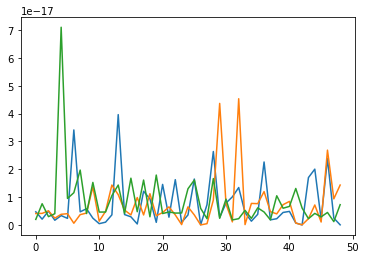

In [11]:
local1_mae, local2_mae, local3_mae = [], [], []
for i in range(len(Val_Loss)):
    local1_mae.append(Loss[i][0]) 
    local2_mae.append(Loss[i][1]) 
    local3_mae.append(Loss[i][2]) 

plt.plot(local1_mae)
plt.plot(local2_mae)
plt.plot(local3_mae)

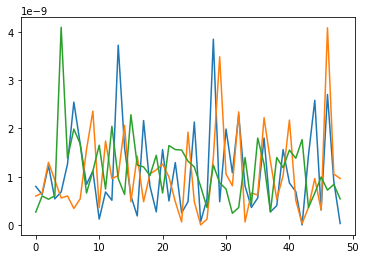

In [12]:
local1_mae, local2_mae, local3_mae = [], [], []
for i in range(len(Val_Loss)):
    local1_mae.append(Val_Loss[i][0]) 
    local2_mae.append(Val_Loss[i][1]) 
    local3_mae.append(Val_Loss[i][2]) 

plt.plot(local1_mae)
plt.plot(local2_mae)
plt.plot(local3_mae)

# 2021.01~08월치 예측

In [13]:
Loss_pred, MAE_pred, Val_pred = [], [], []

for j in range(len(period_5)):
    loss_tmp, mae_tmp, for_graph_tmp = [], [], []
    for local in range(1,num_locals+1):
        df = pd.DataFrame({'local':globals()['train{}_5_{}'.format(local,j)]})

        only_test_dataset = df.sample(frac=1.0,random_state=0)
        
        train_stats = only_test_dataset.describe()
        train_stats = train_stats.transpose()

        normed_test_data = norm(only_test_dataset)
        normed_test_data = np.array(normed_test_data)
        
        normed_test_data = np.reshape(normed_test_data, (normed_test_data.shape[0], 1, normed_test_data.shape[1]))
        
        model = globals()['G{}_Model'.format(g-1)]
        
        trainPredict = model.predict(normed_test_data)
        for_graph_tmp.append(model.predict(normed_test_data))
        
        loss, mae, mse = model.evaluate(normed_test_data, trainPredict, verbose=2)
        
        loss_tmp.append(loss)
        mae_tmp.append(mae)
        
        
    Loss_pred.append(loss_tmp)
    MAE_pred.append(mae_tmp)
    Val_pred.append(for_graph_tmp)
    

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 2.0996e-16 - mae: 6.4892e-09 - mse: 2.0996e-16 - 298ms/epoch - 298ms/step
1/1 [==============================] - 0s 11ms/step
1/1 - 0s - loss: 3.1561e-17 - mae: 2.4034e-09 - mse: 3.1561e-17 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 10ms/step
1/1 - 0s - loss: 9.0094e-17 - mae: 4.3862e-09 - mse: 9.0094e-17 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 11ms/step
1/1 - 0s - loss: 4.2253e-17 - mae: 2.8605e-09 - mse: 4.2253e-17 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.6700e-17 - mae: 4.4570e-09 - mse: 7.6700e-17 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 12ms/step
1/1 - 0s - loss: 3.9899e-17 - mae: 1.7296e-09 - mse: 3.9899e-17 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 12ms/step
1/1 - 0s - loss: 2.0996e-16 - mae: 6.4892e-09 - mse: 2.0996e-16 - 13ms/epoch - 13ms/step
1/1 [======

### local 1

In [14]:
dataset_plot = new_dataset1[len(new_dataset1)-sum(period_5):]

In [15]:
len(Val_pred), len(Val_pred[0]), len(Val_pred[0][0]), len(Val_pred[0][0][0])

(8, 3, 31, 1)

In [16]:
trainPredict_plot = np.empty_like(dataset_plot)
trainPredict_plot[:,:] = np.nan
trainPredict_plot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredict_plot = np.empty_like(dataset)
testPredict_plot[:,:] = np.nan
testPredict_plot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredict_plot)
plt.plot(testPredict_plot)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
local1_mae, local2_mae, local3_mae = [], [], []
for i in range(len(MAE_pred)):
    local1_mae.append(MAE_pred[i][0]) 
    local2_mae.append(MAE_pred[i][1]) 
    local3_mae.append(MAE_pred[i][2]) 

plt.plot(local1_mae)
plt.plot(local2_mae)
plt.plot(local3_mae)